<a href="https://colab.research.google.com/github/khushidubeyokok/AI-ML/blob/main/04_DeepLearning/04_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders
An autoencoder is a neural network that learns to copy its input to its output. But instead of just memorizing, it’s forced to pass data through a compressed hidden layer (latent space). That bottleneck makes it learn useful patterns in the data.

- It has two main parts: an encoder, which compresses the input into a smaller latent vector, and a decoder, which tries to reconstruct the original input from that compressed form.
- The network is trained to minimize the (loss) difference between the input and its reconstruction, forcing it to capture only the most important features.
- In anomaly detection, autoencoders are trained on normal data so they reconstruct it well, while anomalies give high reconstruction error and can be flagged.

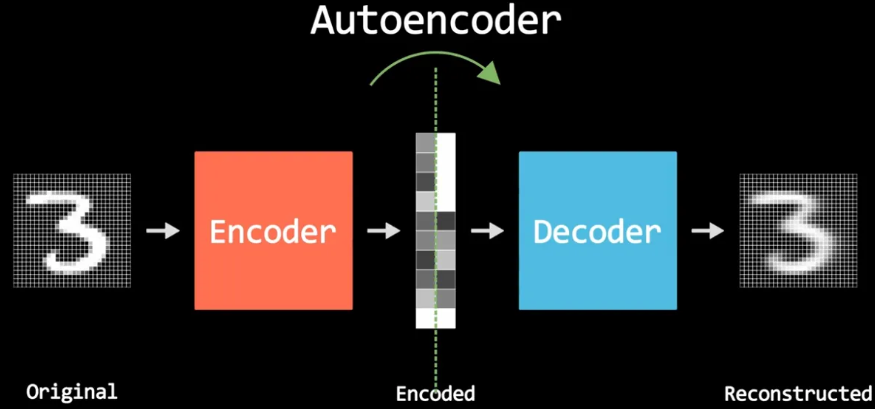

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
transform=transforms.ToTensor()
mnist_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
data_loader=torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.23MB/s]


In [7]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images)) #images are normalised - divided by 255

tensor(0.) tensor(1.)


In [14]:
class AutoEncoder(nn.Module):
  def __init__(self):
    # initially we have size N,784 ie 28*28 pixels, we want our NN to reduce the size repeatedly
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Linear(28*28,128), # (N, 784) -> (N, 128)
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3)
    )  # (N, 784) -> (N, 3)

    self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() #because we want output between 0-1 (normalised images have 0-1 values)
        ) # (N, 3) -> (N, 784)

  def forward(self,x):
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return decoded

# Input [-1, +1] -> use nn.Tanh

In [19]:
model=AutoEncoder()
lossfn=nn.MSELoss(reduction='mean')
optimiser=optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [21]:
# training loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = lossfn(recon, img)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0491
Epoch:2, Loss:0.0460
Epoch:3, Loss:0.0408
Epoch:4, Loss:0.0377
Epoch:5, Loss:0.0397
Epoch:6, Loss:0.0363
Epoch:7, Loss:0.0370
Epoch:8, Loss:0.0353
Epoch:9, Loss:0.0378
Epoch:10, Loss:0.0340


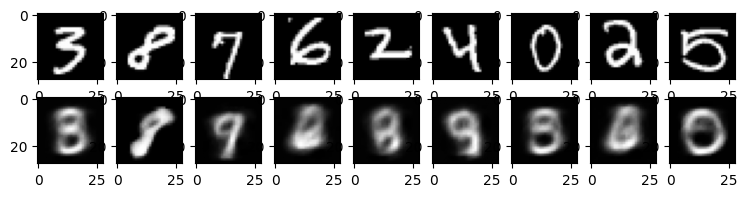

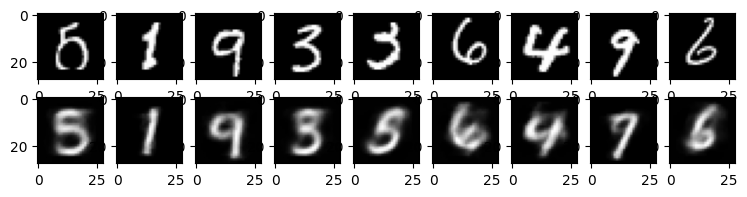

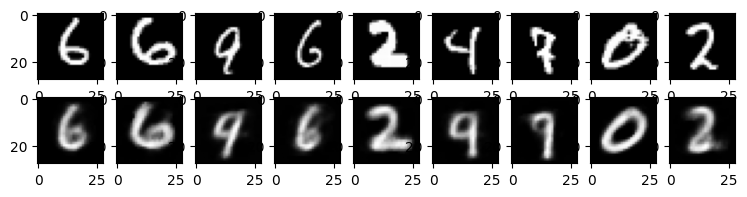

In [23]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])

Using convolutional neural network to improve performance

In [24]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [32]:
model2=Autoencoder_CNN()
lossfn=nn.BCELoss()
optimiser=optim.Adam(model2.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [33]:
# training loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        recon = model2(img)
        loss = lossfn(recon, img)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0910
Epoch:2, Loss:0.0816
Epoch:3, Loss:0.0767
Epoch:4, Loss:0.0728
Epoch:5, Loss:0.0725
Epoch:6, Loss:0.0750
Epoch:7, Loss:0.0661
Epoch:8, Loss:0.0689
Epoch:9, Loss:0.0683
Epoch:10, Loss:0.0720


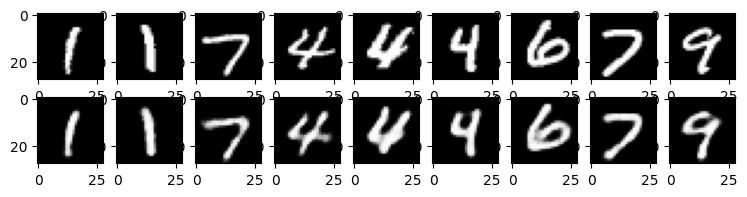

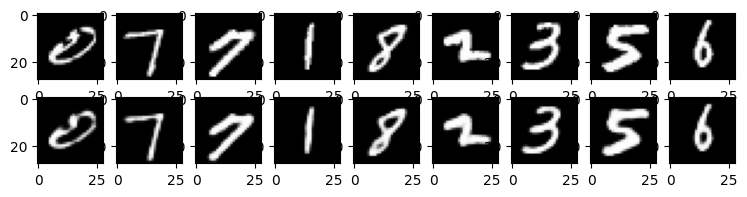

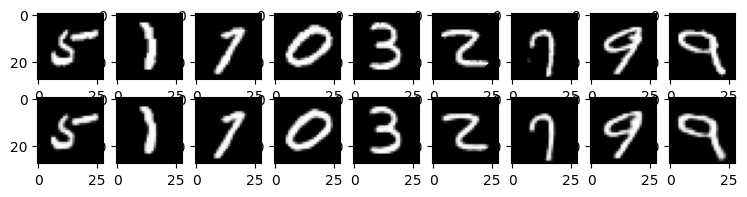

In [35]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])